# Ramen for all!
## Best neighbourhood for a new ramen place in Oslo, Norway

Author: Espen Hagen

In [1]:
# imports
import requests
import pandas as pd
import numpy as np
import random
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
import folium
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

/Users/ehagen/anaconda3/envs/ds/lib/python3.8/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Fetch and process neighbourhood data

In [2]:
# Districts of Oslo
url = requests.get('https://en.wikipedia.org/wiki/List_of_boroughs_of_Oslo').text
boroughs = pd.read_html(url, header=0)[0]
boroughs

,Borough,Residents,Area,Number
0,Alna,45 114,"13,7 km2",12
1,Bjerke,26 229,"7,7 km2",9
2,Frogner,47 618,"8,3 km2",5
3,Gamle Oslo,39 500,"7,5 km2",1
4,Grorud,25 461,"8,2 km2",10
5,Grünerløkka,42 129,"4,8 km2",2
6,Nordre Aker,43 843,"13,6 km2",8
7,Nordstrand,44 802,"16,9 km2",14
8,Sagene,32 394,"3,1 km2",3
9,St. Hanshaugen,30 144,"3,6 km2",4


In [3]:
# convert Area column to float:
for i, area in enumerate(boroughs['Area']):
    boroughs.loc[i, 'Area_km2'] = float(area.strip(' km2').replace(',', '.'))

# drop redundant columns:
boroughs.drop(columns=['Area', 'Number'], inplace=True)
boroughs

,Borough,Residents,Area_km2
0,Alna,45 114,13.7
1,Bjerke,26 229,7.7
2,Frogner,47 618,8.3
3,Gamle Oslo,39 500,7.5
4,Grorud,25 461,8.2
5,Grünerløkka,42 129,4.8
6,Nordre Aker,43 843,13.6
7,Nordstrand,44 802,16.9
8,Sagene,32 394,3.1
9,St. Hanshaugen,30 144,3.6


In [4]:
# insert "Sentrum" as Borough (technically it is mostly a geographic entity, not administratively). 
# data source: https://en.wikipedia.org/wiki/Sentrum,_Oslo; 
boroughs = pd.concat([boroughs, pd.DataFrame([['Sentrum', '1 339', 1.8]], 
                                                   columns=boroughs.columns)], 
                     ignore_index=True)
boroughs

,Borough,Residents,Area_km2
0,Alna,45 114,13.7
1,Bjerke,26 229,7.7
2,Frogner,47 618,8.3
3,Gamle Oslo,39 500,7.5
4,Grorud,25 461,8.2
5,Grünerløkka,42 129,4.8
6,Nordre Aker,43 843,13.6
7,Nordstrand,44 802,16.9
8,Sagene,32 394,3.1
9,St. Hanshaugen,30 144,3.6


In [5]:
# compute population density as residents per km2
boroughs.Residents = pd.to_numeric(boroughs['Residents'].astype('string').str.replace(' ', ''))
boroughs['Residents'] = boroughs['Residents'].astype(int)
boroughs['pop_density'] = boroughs['Residents'] / boroughs['Area_km2']
boroughs

,Borough,Residents,Area_km2,pop_density
0,Alna,45114,13.7,3292.992701
1,Bjerke,26229,7.7,3406.363636
2,Frogner,47618,8.3,5737.108434
3,Gamle Oslo,39500,7.5,5266.666667
4,Grorud,25461,8.2,3105.000000
5,Grünerløkka,42129,4.8,8776.875000
6,Nordre Aker,43843,13.6,3223.750000
7,Nordstrand,44802,16.9,2651.005917
8,Sagene,32394,3.1,10449.677419
9,St. Hanshaugen,30144,3.6,8373.333333


## Fetch and process geolocation and restaurant data

In [6]:
# Foursquare API call settings
CLIENT_ID = 'XXXXXXXXXXX' # Foursquare ID
CLIENT_SECRET = 'XXXXXXXXXXX' # Foursquare Secret
VERSION = '20180604'
LIMIT = 50

In [7]:
# geolocator object
geolocator = Nominatim(user_agent="foursquare_agent", timeout=10)

In [8]:
# enquire the location of each district
latitudes = []
longitudes = []
for borough in boroughs['Borough']:
    address = '{}, Oslo, Norway'.format(borough if not borough=='Gamle Oslo' else 'Kampen'
                                       ) # get proper location for Gamle Oslo
    location = geolocator.geocode(address)
    latitudes += [location.latitude]
    longitudes += [location.longitude]
boroughs['latitude'] = latitudes
boroughs['longitude'] = longitudes
boroughs

,Borough,Residents,Area_km2,pop_density,latitude,longitude
0,Alna,45114,13.7,3292.992701,59.932417,10.835276
1,Bjerke,26229,7.7,3406.363636,59.941395,10.829208
2,Frogner,47618,8.3,5737.108434,59.922224,10.706649
3,Gamle Oslo,39500,7.5,5266.666667,59.912731,10.780247
4,Grorud,25461,8.2,3105.000000,59.961424,10.880549
5,Grünerløkka,42129,4.8,8776.875000,59.925471,10.777421
6,Nordre Aker,43843,13.6,3223.750000,59.953638,10.756412
7,Nordstrand,44802,16.9,2651.005917,59.863525,10.785830
8,Sagene,32394,3.1,10449.677419,59.938273,10.765849
9,St. Hanshaugen,30144,3.6,8373.333333,59.927950,10.738958


In [9]:
# Location of Oslo
address = 'Oslo, Norway'

location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

In [10]:
# visualize locations of districts on map
oslo_map = folium.Map(location=[latitude, longitude], zoom_start=11.2)

cmap = plt.get_cmap('brg', boroughs.shape[0])
for i, (lat, lng, label) in enumerate(zip(boroughs.latitude, boroughs.longitude, boroughs.Borough)):
    color = matplotlib.colors.to_hex(cmap(i))
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color=color,
        popup=label,
        fill = True,
        fill_color=color,
        fill_opacity=1
    ).add_to(oslo_map)

oslo_map

In [11]:
# create dataframe for ramen restaurants in Oslo
search_query = 'ramen'
radius = 20000 # search radius (m)
category='4d4b7105d754a06374d81259' # Foursquare food category

url = 'https://api.foursquare.com/v2/venues/search?'+\
'client_id={}&client_secret={}&near=Oslo,Norge&v={}&query={}&category={}&radius={}&limit={}'.format(
    CLIENT_ID, CLIENT_SECRET, VERSION, search_query, category, radius, LIMIT)

# fetch results
results = requests.get(url).json()

# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
ramen_df = pd.json_normalize(venues)
ramen_df

,id,name,categories,referralId,hasPerk,location.address,location.lat,location.lng,location.labeledLatLngs,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress
0,5dea98b591ebb5000890636d,Ezo Ramen,"[{'id': '55a59bace4b013909087cb24', 'name': 'R...",v-1581689200,False,20 Nordre Gate,59.921151,10.758257,"[{'label': 'display', 'lat': 59.921151, 'lng':...",0551,NO,Oslo,Oslo,Norge,"[20 Nordre Gate, 0551 Oslo, Norge]"
1,5c646f51250cab002ccaec86,Hrímnir Ramen,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",v-1581689200,False,9A Maridalsveien,59.921339,10.751500,"[{'label': 'display', 'lat': 59.921339, 'lng':...",0178,NO,Oslo,Oslo,Norge,"[9A Maridalsveien, 0178 Oslo, Norge]"
2,571b63a2498e1c38c85fd1d3,Sapporo Ramen Bar,"[{'id': '4bf58dd8d48988d1d1941735', 'name': 'N...",v-1581689200,False,NaN,59.923473,10.751495,"[{'label': 'display', 'lat': 59.92347306962917...",NaN,NO,NaN,NaN,Norge,[Norge]
3,57d13c68498e1c27b12f9387,Ramen-Ya,"[{'id': '55a59bace4b013909087cb24', 'name': 'R...",v-1581689200,False,NaN,59.940261,10.721777,"[{'label': 'display', 'lat': 59.940261, 'lng':...",0313,NO,Oslo,Oslo,Norge,"[0313 Oslo, Norge]"
4,59b176f3cad1b6095f6688f4,Koie,"[{'id': '55a59bace4b013909087cb24', 'name': 'R...",v-1581689200,False,Osterhaus gate 13,59.917087,10.752708,"[{'label': 'display', 'lat': 59.91708729191666...",0183,NO,Oslo,Oslo,Norge,"[Osterhaus gate 13, 0183 Oslo, Norge]"


In [12]:
def filter_dataframe(dataframe):
    '''
    helper function to filter categories column in dataframe
    
    Parameters
    ----------
    dataframe : pd.DataFrame object
    
    Returns
    -------
    dataframe : pd.DataFrame object
    
    '''
    # keep only columns that include venue name, and anything that is associated with location
    filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')
                                                ] + ['id']
    dataframe_filtered = dataframe.loc[:, filtered_columns]

    # function that extracts the category of the venue
    def get_category_type(row):
        try:
            categories_list = row['categories']
        except:
            categories_list = row['venue.categories']

        if len(categories_list) == 0:
            return None
        else:
            return categories_list[0]['name']

    # filter the category for each row
    dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

    # clean column names by keeping only last term
    dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]
    
    return dataframe_filtered

In [13]:
# filter categories
ramen_df = filter_dataframe(ramen_df)
ramen_df

,name,categories,address,lat,lng,labeledLatLngs,postalCode,cc,city,state,country,formattedAddress,id
0,Ezo Ramen,Ramen Restaurant,20 Nordre Gate,59.921151,10.758257,"[{'label': 'display', 'lat': 59.921151, 'lng':...",0551,NO,Oslo,Oslo,Norge,"[20 Nordre Gate, 0551 Oslo, Norge]",5dea98b591ebb5000890636d
1,Hrímnir Ramen,Restaurant,9A Maridalsveien,59.921339,10.751500,"[{'label': 'display', 'lat': 59.921339, 'lng':...",0178,NO,Oslo,Oslo,Norge,"[9A Maridalsveien, 0178 Oslo, Norge]",5c646f51250cab002ccaec86
2,Sapporo Ramen Bar,Noodle House,NaN,59.923473,10.751495,"[{'label': 'display', 'lat': 59.92347306962917...",NaN,NO,NaN,NaN,Norge,[Norge],571b63a2498e1c38c85fd1d3
3,Ramen-Ya,Ramen Restaurant,NaN,59.940261,10.721777,"[{'label': 'display', 'lat': 59.940261, 'lng':...",0313,NO,Oslo,Oslo,Norge,"[0313 Oslo, Norge]",57d13c68498e1c27b12f9387
4,Koie,Ramen Restaurant,Osterhaus gate 13,59.917087,10.752708,"[{'label': 'display', 'lat': 59.91708729191666...",0183,NO,Oslo,Oslo,Norge,"[Osterhaus gate 13, 0183 Oslo, Norge]",59b176f3cad1b6095f6688f4


In [14]:
# for each entry, set Borough to the one that minimizes the Borough to restaurant distance
ramen_df.loc[:, 'Borough'] = ''
for i in range(ramen_df.shape[0]):
    dist = np.linalg.norm(np.array(boroughs[['latitude', 'longitude']]) - 
                          np.array(ramen_df.loc[i, ['lat', 'lng']]).astype(float), 
                          axis=1)
    borough = str(np.array(boroughs['Borough'])[dist==dist.min()][0])
    ramen_df.loc[i, 'Borough'] = borough
ramen_df

,name,categories,address,lat,lng,labeledLatLngs,postalCode,cc,city,state,country,formattedAddress,id,Borough
0,Ezo Ramen,Ramen Restaurant,20 Nordre Gate,59.921151,10.758257,"[{'label': 'display', 'lat': 59.921151, 'lng':...",0551,NO,Oslo,Oslo,Norge,"[20 Nordre Gate, 0551 Oslo, Norge]",5dea98b591ebb5000890636d,Sagene
1,Hrímnir Ramen,Restaurant,9A Maridalsveien,59.921339,10.751500,"[{'label': 'display', 'lat': 59.921339, 'lng':...",0178,NO,Oslo,Oslo,Norge,"[9A Maridalsveien, 0178 Oslo, Norge]",5c646f51250cab002ccaec86,Sentrum
2,Sapporo Ramen Bar,Noodle House,NaN,59.923473,10.751495,"[{'label': 'display', 'lat': 59.92347306962917...",NaN,NO,NaN,NaN,Norge,[Norge],571b63a2498e1c38c85fd1d3,St. Hanshaugen
3,Ramen-Ya,Ramen Restaurant,NaN,59.940261,10.721777,"[{'label': 'display', 'lat': 59.940261, 'lng':...",0313,NO,Oslo,Oslo,Norge,"[0313 Oslo, Norge]",57d13c68498e1c27b12f9387,St. Hanshaugen
4,Koie,Ramen Restaurant,Osterhaus gate 13,59.917087,10.752708,"[{'label': 'display', 'lat': 59.91708729191666...",0183,NO,Oslo,Oslo,Norge,"[Osterhaus gate 13, 0183 Oslo, Norge]",59b176f3cad1b6095f6688f4,Sentrum


In [15]:
# visualize locations of ramen places in districts on map
oslo_map = folium.Map(location=[latitude, longitude], zoom_start=12)

for i, borough in enumerate(boroughs.Borough):
    df = ramen_df[ramen_df['Borough']==borough]
    color = matplotlib.colors.to_hex('C{}'.format(i))
    for lat, lng, label in zip(df.lat, df.lng, df.name):
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            color=color,
            popup='{}, {}'.format(label, borough),
            fill = True,
            fill_color=color,
            fill_opacity=1
        ).add_to(oslo_map)

oslo_map

In [16]:
# initializse dataframe for all restaurants
restaurants_df = pd.DataFrame()

# enquire restaurants per district
search_query = 'restaurant'

for (lat, lng, area, borough) in np.array(boroughs[['latitude', 'longitude', 'Area_km2', 'Borough']]):
    # set search radius dependent on district area
    radius = np.sqrt(area / np.pi)*1000*2
    
    url = 'https://api.foursquare.com/v2/venues/search?' + \
'client_id={}&client_secret={}&ll={},{}&v={}&query={}&category={}&radius={}&limit={}'.format(
    CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, search_query, category, radius, LIMIT)
    
    # fetch results
    results = requests.get(url).json()

    # assign relevant part of JSON to venues
    venues = results['response']['venues']

    # tranform venues into a dataframe
    restaurant_df = pd.json_normalize(venues)

    # filter dataframe
    filtered_restaurant_df = filter_dataframe(restaurant_df)
    
    # insert Borough into dataframe (will be modified below)
    filtered_restaurant_df['Borough'] = borough
    
    # store dataframe in list
    restaurants_df = pd.concat([restaurants_df, filtered_restaurant_df], ignore_index=True)

# clean up
del restaurant_df, filtered_restaurant_df

In [17]:
restaurants_df

,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,neighborhood,id,Borough
0,Olsen Restaurant & Bar,Bar,Østensjøveien 62,Jernbaneveien,59.907516,10.818289,"[{'label': 'display', 'lat': 59.90751614126184...",2929,0667,NO,Oslo,Oslo,Norge,"[Østensjøveien 62 (Jernbaneveien), 0667 Oslo, ...",NaN,4c3604a118e72d7f041514f5,Alna
1,Beno Restaurant,Indian Restaurant,NaN,NaN,59.900710,10.833881,"[{'label': 'display', 'lat': 59.90070997666412...",3530,NaN,NO,NaN,NaN,Norge,[Norge],NaN,4e87437f30f8f98faf836274,Alna
2,Restaurant Fusion,Indian Restaurant,NaN,NaN,59.930328,10.793570,"[{'label': 'display', 'lat': 59.930328, 'lng':...",2337,NaN,NO,NaN,NaN,Norge,[Norge],NaN,4c18e51f834e2d7fd0802980,Alna
3,Sechuan Chengdu Restaurant,Chinese Restaurant,Trondheimsveien 64,Vardøgata,59.923124,10.771860,"[{'label': 'display', 'lat': 59.92312375867008...",3685,0565,NO,Oslo,Oslo,Norge,"[Trondheimsveien 64 (Vardøgata), 0565 Oslo, No...",NaN,4bcd4b07cc8cd13a4e71c2cf,Alna
4,IKEA Restauranten,Restaurant,IKEA,Strømsveien 303,59.933697,10.871380,"[{'label': 'display', 'lat': 59.93369736118272...",2018,1081,NO,Oslo,Oslo,Norge,"[IKEA (Strømsveien 303), 1081 Oslo, Norge]",NaN,4f76f20ee4b0e5e2ba2ff674,Alna
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
464,Agra Restaurant & Bar,Indian Restaurant,Stranden 3,NaN,59.912252,10.727272,"[{'label': 'display', 'lat': 59.91225225703243...",922,0250,NO,Oslo,Oslo,Norge,"[Stranden 3, 0250 Oslo, Norge]",NaN,4b585afbf964a5201f5428e3,Sentrum
465,Peking Sichuan Restaurant,Szechuan Restaurant,Munchs Gate 5,NaN,59.917224,10.741035,"[{'label': 'display', 'lat': 59.91722364155252...",817,NaN,NO,Oslo,Oslo,Norge,"[Munchs Gate 5, Oslo, Norge]",NaN,533ef115498ea3876ddb3322,Sentrum
466,Caroline Restaurant,Breakfast Spot,NaN,NaN,59.914452,10.733463,"[{'label': 'display', 'lat': 59.914452, 'lng':...",736,NaN,NO,Oslo,Oslo,Norge,"[Oslo, Norge]",NaN,4df6fe8cd1642d7385a5587c,Sentrum
467,Il Vero Bar & Restaurant,Italian Restaurant,Dronning Eufemias gate 18,NaN,59.907877,10.759043,"[{'label': 'display', 'lat': 59.90787659070295...",916,0191,NO,Oslo,Oslo,Norge,"[Dronning Eufemias gate 18, 0191 Oslo, Norge]",NaN,5620fa2a498eef9b30d880be,Sentrum


In [18]:
# concatenate ramen restaurants (may not be fetched by foursquare queries)
restaurants_df = pd.concat([restaurants_df, ramen_df], ignore_index=True)

In [19]:
# remove duplicate rows
restaurants_df.drop_duplicates(subset=['name', 'lat', 'lng'], inplace=True, ignore_index=True)
restaurants_df

,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,neighborhood,id,Borough
0,Olsen Restaurant & Bar,Bar,Østensjøveien 62,Jernbaneveien,59.907516,10.818289,"[{'label': 'display', 'lat': 59.90751614126184...",2929.0,0667,NO,Oslo,Oslo,Norge,"[Østensjøveien 62 (Jernbaneveien), 0667 Oslo, ...",NaN,4c3604a118e72d7f041514f5,Alna
1,Beno Restaurant,Indian Restaurant,NaN,NaN,59.900710,10.833881,"[{'label': 'display', 'lat': 59.90070997666412...",3530.0,NaN,NO,NaN,NaN,Norge,[Norge],NaN,4e87437f30f8f98faf836274,Alna
2,Restaurant Fusion,Indian Restaurant,NaN,NaN,59.930328,10.793570,"[{'label': 'display', 'lat': 59.930328, 'lng':...",2337.0,NaN,NO,NaN,NaN,Norge,[Norge],NaN,4c18e51f834e2d7fd0802980,Alna
3,Sechuan Chengdu Restaurant,Chinese Restaurant,Trondheimsveien 64,Vardøgata,59.923124,10.771860,"[{'label': 'display', 'lat': 59.92312375867008...",3685.0,0565,NO,Oslo,Oslo,Norge,"[Trondheimsveien 64 (Vardøgata), 0565 Oslo, No...",NaN,4bcd4b07cc8cd13a4e71c2cf,Alna
4,IKEA Restauranten,Restaurant,IKEA,Strømsveien 303,59.933697,10.871380,"[{'label': 'display', 'lat': 59.93369736118272...",2018.0,1081,NO,Oslo,Oslo,Norge,"[IKEA (Strømsveien 303), 1081 Oslo, Norge]",NaN,4f76f20ee4b0e5e2ba2ff674,Alna
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,Ezo Ramen,Ramen Restaurant,20 Nordre Gate,NaN,59.921151,10.758257,"[{'label': 'display', 'lat': 59.921151, 'lng':...",NaN,0551,NO,Oslo,Oslo,Norge,"[20 Nordre Gate, 0551 Oslo, Norge]",NaN,5dea98b591ebb5000890636d,Sagene
135,Hrímnir Ramen,Restaurant,9A Maridalsveien,NaN,59.921339,10.751500,"[{'label': 'display', 'lat': 59.921339, 'lng':...",NaN,0178,NO,Oslo,Oslo,Norge,"[9A Maridalsveien, 0178 Oslo, Norge]",NaN,5c646f51250cab002ccaec86,Sentrum
136,Sapporo Ramen Bar,Noodle House,NaN,NaN,59.923473,10.751495,"[{'label': 'display', 'lat': 59.92347306962917...",NaN,NaN,NO,NaN,NaN,Norge,[Norge],NaN,571b63a2498e1c38c85fd1d3,St. Hanshaugen
137,Ramen-Ya,Ramen Restaurant,NaN,NaN,59.940261,10.721777,"[{'label': 'display', 'lat': 59.940261, 'lng':...",NaN,0313,NO,Oslo,Oslo,Norge,"[0313 Oslo, Norge]",NaN,57d13c68498e1c27b12f9387,St. Hanshaugen


In [20]:
# for each entry, set Borough to the one that minimizes the Borough to restaurant distance
for i in range(restaurants_df.shape[0]):
    dist = np.linalg.norm(np.array(boroughs[['latitude', 'longitude']]) - 
                          np.array(restaurants_df.loc[i, ['lat', 'lng']]).astype(float), axis=1)
    borough = str(np.array(boroughs['Borough'])[dist==dist.min()][0])
    restaurants_df.loc[i, 'Borough'] = borough
restaurants_df

,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,neighborhood,id,Borough
0,Olsen Restaurant & Bar,Bar,Østensjøveien 62,Jernbaneveien,59.907516,10.818289,"[{'label': 'display', 'lat': 59.90751614126184...",2929.0,0667,NO,Oslo,Oslo,Norge,"[Østensjøveien 62 (Jernbaneveien), 0667 Oslo, ...",NaN,4c3604a118e72d7f041514f5,Østensjø
1,Beno Restaurant,Indian Restaurant,NaN,NaN,59.900710,10.833881,"[{'label': 'display', 'lat': 59.90070997666412...",3530.0,NaN,NO,NaN,NaN,Norge,[Norge],NaN,4e87437f30f8f98faf836274,Østensjø
2,Restaurant Fusion,Indian Restaurant,NaN,NaN,59.930328,10.793570,"[{'label': 'display', 'lat': 59.930328, 'lng':...",2337.0,NaN,NO,NaN,NaN,Norge,[Norge],NaN,4c18e51f834e2d7fd0802980,Grünerløkka
3,Sechuan Chengdu Restaurant,Chinese Restaurant,Trondheimsveien 64,Vardøgata,59.923124,10.771860,"[{'label': 'display', 'lat': 59.92312375867008...",3685.0,0565,NO,Oslo,Oslo,Norge,"[Trondheimsveien 64 (Vardøgata), 0565 Oslo, No...",NaN,4bcd4b07cc8cd13a4e71c2cf,Grünerløkka
4,IKEA Restauranten,Restaurant,IKEA,Strømsveien 303,59.933697,10.871380,"[{'label': 'display', 'lat': 59.93369736118272...",2018.0,1081,NO,Oslo,Oslo,Norge,"[IKEA (Strømsveien 303), 1081 Oslo, Norge]",NaN,4f76f20ee4b0e5e2ba2ff674,Grorud
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,Ezo Ramen,Ramen Restaurant,20 Nordre Gate,NaN,59.921151,10.758257,"[{'label': 'display', 'lat': 59.921151, 'lng':...",NaN,0551,NO,Oslo,Oslo,Norge,"[20 Nordre Gate, 0551 Oslo, Norge]",NaN,5dea98b591ebb5000890636d,Sagene
135,Hrímnir Ramen,Restaurant,9A Maridalsveien,NaN,59.921339,10.751500,"[{'label': 'display', 'lat': 59.921339, 'lng':...",NaN,0178,NO,Oslo,Oslo,Norge,"[9A Maridalsveien, 0178 Oslo, Norge]",NaN,5c646f51250cab002ccaec86,Sentrum
136,Sapporo Ramen Bar,Noodle House,NaN,NaN,59.923473,10.751495,"[{'label': 'display', 'lat': 59.92347306962917...",NaN,NaN,NO,NaN,NaN,Norge,[Norge],NaN,571b63a2498e1c38c85fd1d3,St. Hanshaugen
137,Ramen-Ya,Ramen Restaurant,NaN,NaN,59.940261,10.721777,"[{'label': 'display', 'lat': 59.940261, 'lng':...",NaN,0313,NO,Oslo,Oslo,Norge,"[0313 Oslo, Norge]",NaN,57d13c68498e1c27b12f9387,St. Hanshaugen


In [21]:
# visualize locations of restaurants on map
oslo_map = folium.Map(location=[latitude, longitude], zoom_start=12)

cmap = plt.get_cmap('brg', boroughs.shape[0])
for i, borough in enumerate(boroughs.Borough):
    df = restaurants_df[restaurants_df['Borough']==borough]
    color = matplotlib.colors.to_hex(cmap(i))
    for lat, lng, label in zip(df.lat, df.lng, df.name):
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            color=color,
            popup=folium.Popup('{}, {}'.format(label, borough), True),
            fill = True,
            fill_color=color,
            fill_opacity=1
        ).add_to(oslo_map)

oslo_map

## Dimensionality reduction and analysis

In [22]:
# restaurants and ramen places per area
boroughs['n_restaurants'] = 0
boroughs['n_ramens'] = 0

for i, borough in enumerate(boroughs['Borough']):
    boroughs.loc[i, 'n_restaurants'] = (restaurants_df['Borough'] == borough).sum()
    boroughs.loc[i, 'n_ramens'] = (ramen_df['Borough'] == borough).sum()
boroughs

,Borough,Residents,Area_km2,pop_density,latitude,longitude,n_restaurants,n_ramens
0,Alna,45114,13.7,3292.992701,59.932417,10.835276,2,0
1,Bjerke,26229,7.7,3406.363636,59.941395,10.829208,4,0
2,Frogner,47618,8.3,5737.108434,59.922224,10.706649,16,0
3,Gamle Oslo,39500,7.5,5266.666667,59.912731,10.780247,8,0
4,Grorud,25461,8.2,3105.000000,59.961424,10.880549,1,0
5,Grünerløkka,42129,4.8,8776.875000,59.925471,10.777421,9,0
6,Nordre Aker,43843,13.6,3223.750000,59.953638,10.756412,1,0
7,Nordstrand,44802,16.9,2651.005917,59.863525,10.785830,0,0
8,Sagene,32394,3.1,10449.677419,59.938273,10.765849,9,1
9,St. Hanshaugen,30144,3.6,8373.333333,59.927950,10.738958,11,2


Text(0.5, 1.0, 'population density vs. number of ramen restaurants')

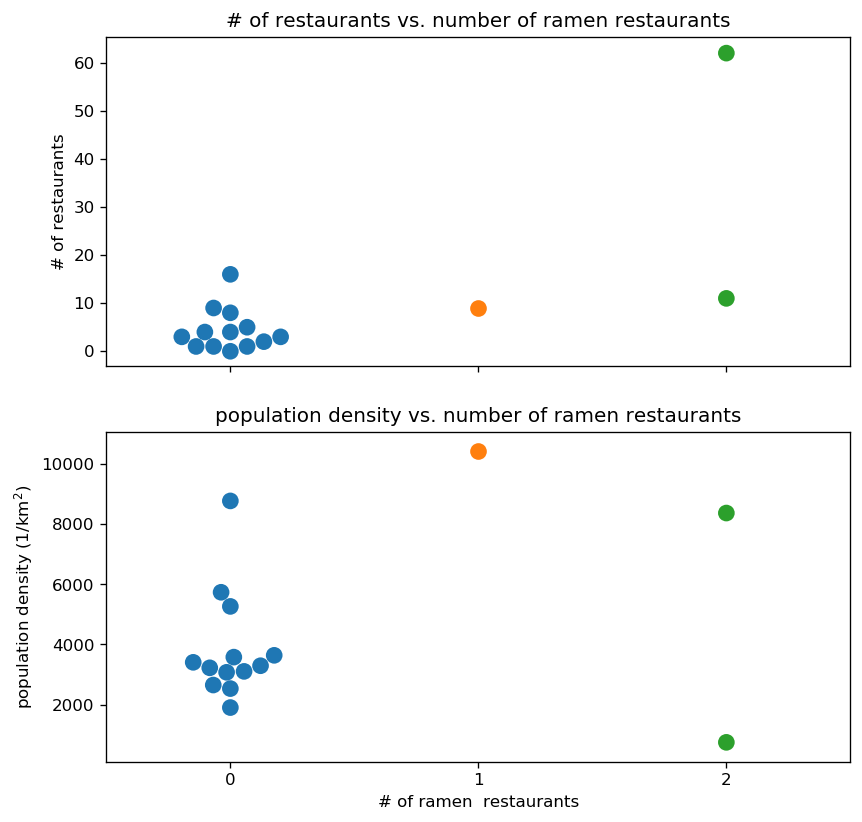

In [23]:
# Visual data summary
fig, axes = plt.subplots(2,1, sharex=True,  dpi=120, figsize=(8, 8))
sns.swarmplot(x='n_ramens', y='n_restaurants', data=boroughs, ax=axes[0], size=10)
axes[0].set_xlabel('')
axes[0].set_ylabel('# of restaurants')
axes[0].set_title('# of restaurants vs. number of ramen restaurants')
sns.swarmplot(x='n_ramens', y='pop_density', data=boroughs, ax=axes[1], size=10)
axes[1].set_xlabel('# of ramen  restaurants')
axes[1].set_ylabel(r'population density (1/km$^{2}$)')
axes[1].set_title('population density vs. number of ramen restaurants')

Text(0.5, 1.0, '# of resturants vs. population density')

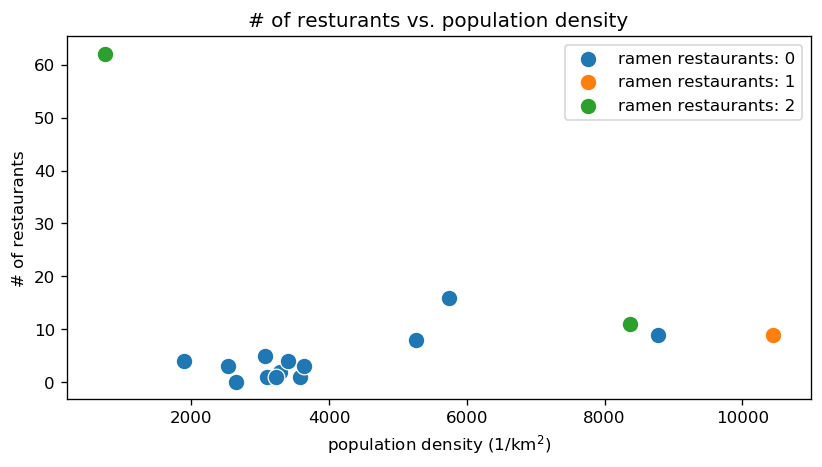

In [24]:
# population density vs. population density in districts without ramen
fig, ax = plt.subplots(1, 1, dpi=120, figsize=(8, 4))
for n in np.unique(boroughs['n_ramens']):
    sns.scatterplot(x='pop_density', y='n_restaurants', 
                    data=boroughs[boroughs['n_ramens']==n], 
                    s=100, label='ramen restaurants: {}'.format(n))
ax.set_xlabel(r'population density (1/km$^{2}$)')
ax.set_ylabel('# of restaurants')
ax.set_title('# of resturants vs. population density')

In [25]:
# With many unserved districts, it is obvious that the best neighbourhood for a new establishment
# is the one unserved district without any ramen
df = boroughs[boroughs['n_ramens']==0]
borough = df[df['pop_density']==df['pop_density'].max()]
best_location = borough['Borough'].to_string(index=False)
print('Best neighbourhood for new ramen:{}!'.format(best_location))

Best neighbourhood for new ramen: Grünerløkka!


In [26]:
# display row
borough

,Borough,Residents,Area_km2,pop_density,latitude,longitude,n_restaurants,n_ramens
5,Grünerløkka,42129,4.8,8776.875,59.925471,10.777421,9,0


In [27]:
# visualize location
oslo_map = folium.Map(location=[latitude, longitude], zoom_start=13)

#for i, (lat, lng, label) in enumerate(zip(boroughs.latitude, boroughs.longitude, boroughs.Borough)):
lat = float(borough.latitude)
lng = float(borough.longitude)
label = best_location
color = matplotlib.colors.to_hex('C0')
folium.CircleMarker(
    [lat, lng],
    radius=5,
    color=color,
    popup=label,
    fill = True,
    fill_color=color,
    fill_opacity=1
).add_to(oslo_map)

oslo_map